In [1]:
import sys

sys.path.append("..")

In [2]:
from src.preprocessing import *
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.feature_selection import RFECV, RFE
import src.config as config
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [93]:
import talib as ta
import sklearn.tree as tree
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import KernelPCA, PCA

In [95]:
sample_weight = compute_sample_weight(
    {
        "strong buy": 1,
        "strong sell": 1,
        "meh": 0.1,
        "sell": 0.5,
        "buy": 0.5,
    },
)

In [97]:
sample_weight

array([1. , 1. , 1. , ..., 0.5, 1. , 0.5])

In [88]:
df = pd.read_csv("../data/data.csv")
X, y = prep_data(df, config.LAGS, config.FUTURE_PRED, config.MULTIPLIER_FOR_DESIRED_POS)

Generating desired position...
Desired position generated
Generating original features...
Generating momentum features...
Generating math features...
Generating pattern features...
Generating time features...
All features generated
Splitting features/target
Features/target split complete


In [73]:
y.columns

Index(['pos_change_signal', 'net_pos_signal', 'desired_pos_change',
       'desired_pos_rolling'],
      dtype='object')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [112]:
pipe = make_pipeline(
    PCA(n_components=19),
    RandomForestClassifier(
        max_depth=5,
        min_samples_leaf=1000,
        min_samples_split=8000,
        n_estimators=600,
        warm_start=True,
        n_jobs=-1,
    ),
)

In [102]:
pipe2 = make_pipeline(
    PCA(n_components=19),
    RandomForestClassifier(
        max_depth=5,
        min_samples_leaf=1000,
        min_samples_split=8000,
        n_estimators=600,
        warm_start=True,
        n_jobs=-1,
    ),
)

In [113]:
model_poschange = pipe.fit(X_train, y_train["pos_change_signal"])

In [103]:
model_netpos = pipe2.fit(X_train, y_train["net_pos_signal"])

In [110]:
y_pred_netpos = model_netpos.predict(X_train)

In [111]:
pd.Series(y_pred_netpos).value_counts()

short hold    157446
long hold     145973
dtype: int64

In [114]:
y_pred_poschange = model_poschange.predict(X_train)

In [80]:
y_pred_train = model.predict(X_train)
y_train_pos_mapped = np.apply_along_axis(
    lambda x: pos_map[x[0]], 1, y_pred_train.reshape(-1, 1)
)
y_train["pred"] = y_train_pos_mapped
y_train["cum_pos"] = y_train["pred"].rolling(10).sum()
y_train["returns"] = (df["close"] - df["open"])[: len(y_train)]
y_train["model_returns"] = y_train["returns"] * y_train["pred"]
y_train.model_returns.cumsum().plot()

ValueError: operands could not be broadcast together with shapes (303419,2) (303419,5) (303419,2) 

In [52]:
pd.Series(y_pred).value_counts()

strong sell    23416
strong buy     18606
sell           18320
buy            11289
meh             4224
dtype: int64

In [53]:
pd.Series(y_pos_mapped).value_counts()

 0    33833
-1    23416
 1    18606
dtype: int64

In [38]:
# map
pos_map = {
    "strong buy": 1,
    "strong sell": -1,
    "meh": 0,
    "buy": 0,
    "sell": 0,
}
y_pos_mapped = np.apply_along_axis(lambda x: pos_map[x[0]], 1, y_pred.reshape(-1, 1))

In [41]:
y_pos_mapped.shape

(75855,)

In [42]:
y_test["pred"] = y_pos_mapped

In [82]:
y_test["cum_pos"] = y_test["pred"].rolling(10).sum()

<AxesSubplot:>

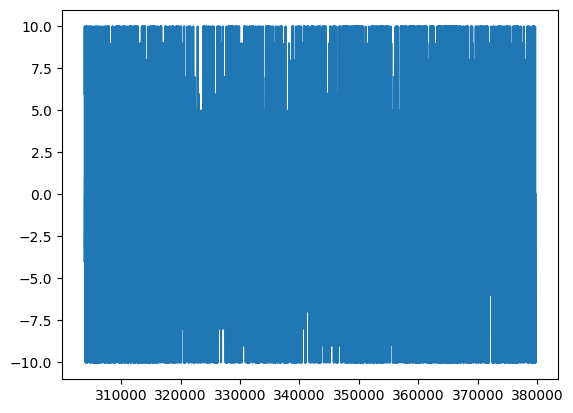

In [83]:
y_test.cum_pos.plot()

In [84]:
y_test["returns"] = (df["close"] - df["open"])[-len(y_test) :]

<AxesSubplot:>

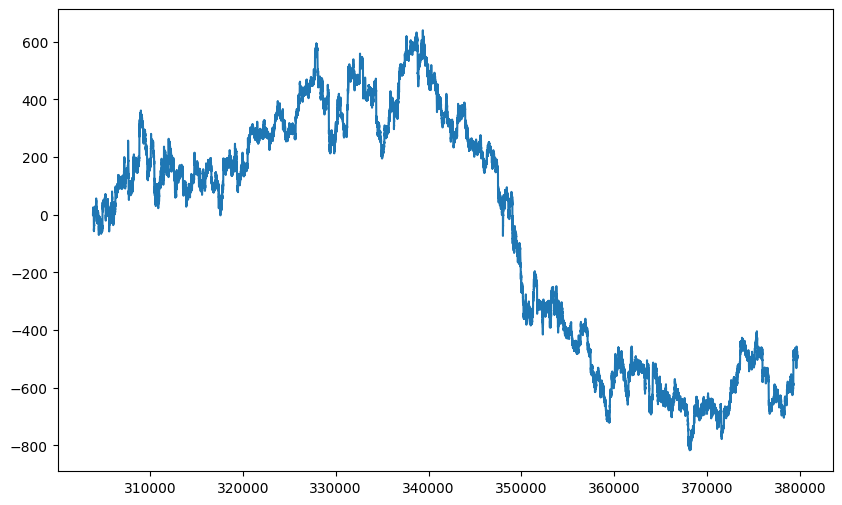

In [85]:
y_test.returns.cumsum().plot(figsize=(10, 6))

In [86]:
y_test["model_returns"] = y_test.returns * y_test.cum_pos

<AxesSubplot:>

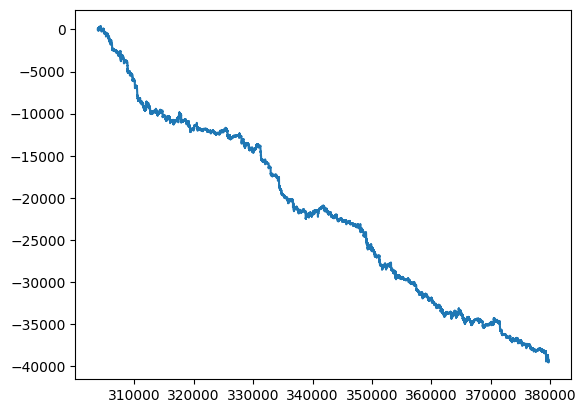

In [87]:
y_test.model_returns.cumsum().plot()

In [62]:
params = {
    "pca__n_components": [i for i in range(1, 20)],
    "randomforestclassifier__n_estimators": [i for i in range(100, 2000, 100)],
    "randomforestclassifier__max_depth": [None, 5, 10, 20],
    "randomforestclassifier__min_samples_split": [i for i in range(1, 20000, 1000)],
    "randomforestclassifier__min_samples_leaf": [i for i in range(1, 20000, 1000)],
    "randomforestclassifier__warm_start": [True],
}

In [63]:
search = RandomizedSearchCV(
    pipe,
    params,
    n_iter=100,
    n_jobs=-1,
    verbose=3,
    cv=5,
    scoring="accuracy",
    random_state=42,
)

In [67]:
pipe.fit(X_train, y_train["pos_change_signal"])

In [43]:
dim_reduction = PCA(n_components=10)

In [44]:
X_trainsformed = dim_reduction.fit_transform(X_train)

In [59]:
clf = RandomForestClassifier()
clf.fit(X_trainsformed, y_train["pos_change_signal"])
clf.score(dim_reduction.transform(X_test), y_test["pos_change_signal"])

0.34295695735284426

In [52]:
dim_reduction.get_feature_names_out()

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7',
       'pca8', 'pca9'], dtype=object)

In [32]:
y_train.columns

Index(['pos_change_signal', 'net_pos_signal', 'desired_pos_change',
       'desired_pos_rolling'],
      dtype='object')

<AxesSubplot:>

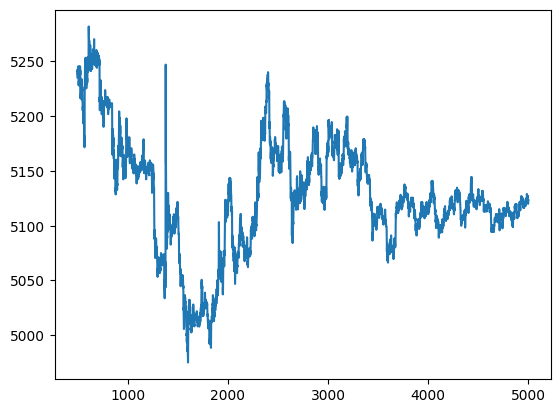

In [39]:
df.close[500:5000].plot()

<AxesSubplot:>

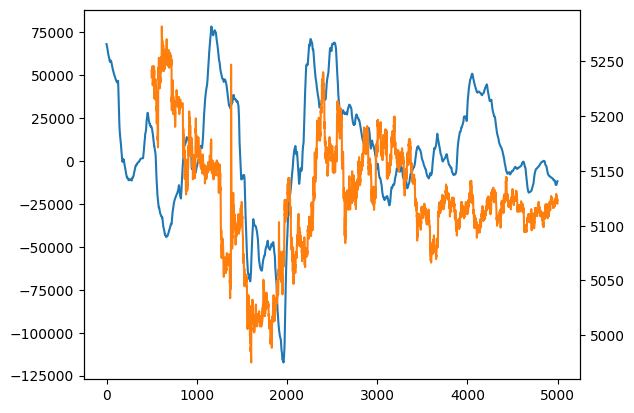

In [42]:
plt.plot(X_trainsformed[:5000])
df.close[500:5000].plot(secondary_y=True)

In [18]:
feature_selector = SelectKBest(mutual_info_classif, k=10)

In [9]:
feature_selector = RFE(
    DecisionTreeClassifier(max_depth=10),
    step=10,
    verbose=3,
)

In [11]:
X_transformed = feature_selector.fit_transform(X_train, y_train["pos_change_signal"])

Fitting estimator with 581 features.


In [20]:
feature_selector.get_feature_names_out()

array(['APO_7', 'CCI_17', 'CMO_7', 'LINEARREG_ANGLE_17',
       'LINEARREG_SLOPE_17', 'MACDSIGNAL_7', 'MOM_7', 'PPO_7', 'ROC_7',
       'RSI_7'], dtype=object)

In [45]:
ValidationCurveDisplay.from_estimator(
    clf,
    X,
    y["pos_change_signal"],
    param_name="max_depth",
    param_range=[i for i in range(1, 50, 5)],
    scoring="accuracy",
)

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, min_samples_split=10000)

In [ ]:
X_train

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
print(metrics.classification_report(y_test, clf.predict(X_test)))

In [ ]:
df = pd.read_csv("../data/data.csv")

In [ ]:
df = prepare_desired_pos(df, 10, 10)

In [ ]:
df.desired_pos_change.plot()

In [ ]:
df[["pos_change_signal", "net_pos_signal"]].value_counts().plot(kind="pie")

In [ ]:
rle(df, True)

In [ ]:
df["daily_pnl"] = df["desired_pos_rolling"] * (df["close"] - df["open"])

In [ ]:
df.daily_pnl.cumsum().plot()

In [ ]:
output = ta_map["SMA"](inputs)

In [ ]:
output

In [ ]:
ta.RSI.parameters

In [ ]:
from talib import abstract

abstract.SMA.parameters

In [ ]:
df = pd.read_csv("data.csv")

In [ ]:
generate_time_features(df)

In [ ]:
df.datetime

In [ ]:
with open("feature_names.txt", "r") as f:
    features = f.read()

In [ ]:
import re

# Save this for production use!

In [ ]:
with open("feature_names.txt", "r") as f:
    features = f.read()
feats = re.findall(r"(\w+\D)(\d+\b)", features)
func_pool = []

In [ ]:
for func in feats:
    if func[0] == "MACDHIST" or func[0] == "MACDSIGNAL":
        continue
    if func[0] == "MACDSIGNALFIX" or func[0] == "MACDHISTFIX":
        continue
    if func[0] == "STOCHRSI_k" or func[0] == "STOCHRSI_d":
        continue
    if func[0] == "HT_PHASORinphase" or func[0] == "HT_PHASORquadrature":
        func[0] = "HT_PHASOR"
    if func[0] == "HT_SINEsine" or func[0] == "HT_SINEleadsine":
        func[0] = "HT_SINE"
    function = getattr(ta, func[0])
    func_pool.append((function, int(func[1])))

In [ ]:
inspect.signature(func_pool[0][0])

In [ ]:
import inspect

In [ ]:
for func, lag in func_pool:
    parameters = inspect.signature(func).parameters

In [ ]:
import talib as ta

In [ ]:
getattr(ta, feats[0][0])